In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sp
from sklearn.preprocessing  import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

c:\python\tf_test\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def configuraConjuntoInicial(caminhoArquivo=None,colunas=None):
    if caminhoArquivo is None:
        caminhoArquivo = 'DECFEC_light_2000_2017.csv'
    dataSet = pd.read_csv(caminhoArquivo)
    # mes_normalizado = np.array([float(i.split("-")[1])/12 for i in dataSet.index])
    # dataSet['Data'] = pd.to_datetime(dataSet["Data"])
    dataSet = dataSet.set_index(["Data"])
    if colunas is not None:
        dataSet = dataSet[colunas]
    return dataSet

In [3]:
def separaConjuntosDeTreinoETeste(conjunto, dataReferencia=None):
    
    if dataReferencia is None:
        dataReferencia = '2016-01-01'
    conjuntoTreino = conjunto[:dataReferencia]
    conjuntoTreino = conjuntoTreino[:-1]
    conjuntoTeste = conjunto[dataReferencia:]
    return conjuntoTreino,conjuntoTeste

In [4]:
def normalizaConjunto(conjunto):
    
    scaler = MinMaxScaler()
    colunasConjunto = [i for i in conjunto]
    conjuntoNormalizado = scaler.fit_transform(pd.DataFrame(conjunto))
    conjuntoNormalizado  = pd.DataFrame(conjuntoNormalizado, index=conjunto.index,columns=colunasConjunto)
    return conjuntoNormalizado,scaler

In [5]:
def separaPorIntervalosDeProbabilidade(serie,intervalos):
    valores = serie.values.flatten().tolist()
    prob_acumulada=[]
    conjuntoNormalizado=[]
    for i in range(len(intervalos)):
        ocorrencias = (len([x for x in valores if (x <= intervalos[i])])/len(valores))
        intervalos[i] = round(intervalos[i],2)
        ocorrencias = round(ocorrencias, 5)
        prob_acumulada.append(ocorrencias)
    
    plt.hist(valores,cumulative=True,density = True)
    plt.show()
    print('Intervalos:')
    print(intervalos)
    print('Probabilidades acumuladas:')
    print(prob_acumulada)
    return prob_acumulada, intervalos

In [6]:
def normalizaNumero(numero,probMin,probMax,valorMin,valorMax):
    
    return (probMin + (numero-valorMin)*(probMax - probMin)/(valorMax - valorMin))

def inverteNormalizacaoNumero(numero,probMin,probMax,valorMin,valorMax):
    return (valorMin + (numero-probMin)*(valorMax - valorMin)/(probMax - probMin))

In [7]:
def normalizaSeriePorTrechos(serie,trechos,probabilidades,showPlot=False):
    
    serie_normalizada = []
    for i in range(serie.size):
        valor = serie.iloc[i].values[0]
        indice_maior = np.where(np.array(trechos)  > valor)[0][0]
        serie_normalizada.append(normalizaNumero(numero=valor,probMin=probabilidades[indice_maior-1],probMax=probabilidades[indice_maior],valorMin=trechos[indice_maior-1],valorMax=trechos[indice_maior]))
    serie_normalizada = np.array(serie_normalizada)
    
    if(showPlot):
        dataSetparaPlot = pd.DataFrame(serie_normalizada,columns=['Série Normalizada'],index= pd.to_datetime(serie.index)) 
        ax = dataSetparaPlot.plot(figsize=(12,7),grid=True)
        plt.show()
    
    dataSetNormalizado = pd.DataFrame(serie_normalizada,columns=['Série Normalizada'],index=serie.index)
    
    return dataSetNormalizado

def inverteNormalizacaoPorTrechos(serie,trechos,probabilidades,showPlot=False):
    serie_invertida = []
    for i in range(serie.size):
        valor = serie.iloc[i].values[0]
        indice_maior = np.where(np.array(probabilidades)  > valor)[0][0]
        serie_invertida.append(inverteNormalizacaoNumero(numero=valor,probMin=probabilidades[indice_maior-1],probMax=probabilidades[indice_maior],valorMin=trechos[indice_maior-1],valorMax=trechos[indice_maior]))
    serie_invertida = np.array(serie_invertida)
    
    if(showPlot):
        dataSetparaPlot = pd.DataFrame(serie_invertida,index=pd.to_datetime(serie.index))
        dataSetparaPlot.plot(figsize=(12,7),grid=True)
        plt.show()
    
    dataSetInvertido = pd.DataFrame(serie_invertida,columns=['Série Normalizada'],index=serie.index) 
    
    return dataSetInvertido

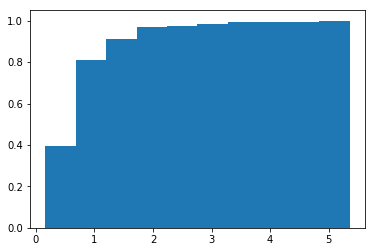

Intervalos:
[0, 1, 2, 6]
Probabilidades acumuladas:
[0.0, 0.69907, 0.94444, 1.0]


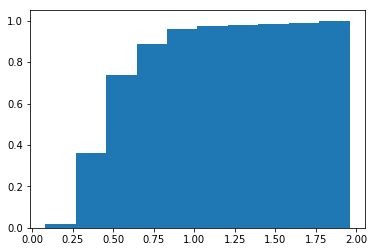

Intervalos:
[0, 0.6, 2]
Probabilidades acumuladas:
[0.0, 0.68056, 1.0]


In [8]:
dec = configuraConjuntoInicial(colunas=['DEC'])
probAcumuladaDEC,intervalosDEC = separaPorIntervalosDeProbabilidade(dec,intervalos=[0,1,2,6])

decNormalizado = normalizaSeriePorTrechos(serie=dec,trechos=intervalosDEC,probabilidades=probAcumuladaDEC)
# decReconstruido = inverteNormalizacaoPorTrechos(serie=decNormalizado,trechos=intervalosDEC,probabilidades=probAcumuladaDEC)

fec = configuraConjuntoInicial(colunas=['FEC'])
probAcumuladaFEC,intervalosFEC = separaPorIntervalosDeProbabilidade(fec,intervalos=[0,0.6, 2])


In [9]:
def codificaMesesDoConjunto(conjunto):
    mesCodificado = np.array([float(i.split("-")[1])/12 for i in conjunto.index])
    return mesCodificado

In [10]:
def configuraConjuntosDeEntradaEDeReferencia(conjuntoDeDados, janelasDeObservacao=None,atraso=1, colunaAdicional=None,labelColunaAdicional=None):
    
    if janelasDeObservacao is None:
        janelasDeObservacao = 12
    dataSetDeEntrada = []
    dataSetDeReferencia = []
    
    for ii in range(len(conjuntoDeDados) - janelasDeObservacao):
        janelaDeDados = conjuntoDeDados[ii:ii+ janelasDeObservacao]
        valorDeReferencia = conjuntoDeDados[ii+janelasDeObservacao]
        dataSetDeEntrada.append(janelaDeDados)
        dataSetDeReferencia.append(valorDeReferencia)
    
    dataSetDeEntrada = np.array(dataSetDeEntrada)
    dataSetDeReferencia = np.array(dataSetDeReferencia)
    conjuntoDeEntrada = pd.DataFrame(dataSetDeEntrada)
    conjuntoDeReferencia = pd.DataFrame(dataSetDeReferencia)
    
    if colunaAdicional is not None and labelColunaAdicional is not None:
        conjuntoDeEntrada[labelColunaAdicional] = colunaAdicional[janelasDeObservacao:]
    return conjuntoDeEntrada, conjuntoDeReferencia


In [11]:
def configuraRedeMLP(conjuntoEntrada,conjuntoSaida,neuronios_1=None,neuronios_2=None,showPlot=False):
    
    dimEntrada = len([i for i in conjuntoEntrada])
    conjuntoEntrada = conjuntoEntrada.values
    conjuntoSaida = conjuntoSaida.values
    
    earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 100, verbose = 1)
    K.clear_session()
    model = Sequential()
    if neuronios_1 is None:
        neuronios_1 = 12
    model.add(Dense(neuronios_1,  input_shape=(dimEntrada,),activation='relu',kernel_initializer ='random_normal'))
    
    if neuronios_2 is not None:
        model.add(Dense(neuronios_2, input_shape=(neuronios_1,), activation='relu'))
    
    # model.add(Dense(3, input_shape=(6,), activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error',metrics=['mae'])
    historico = model.fit(conjuntoEntrada , conjuntoSaida,
                validation_split=0.20, epochs=1000,
                callbacks=[earlyStopping], verbose=0)
    if(showPlot):
        model.summary()
        plt.plot(historico.history['mean_absolute_error'])
        plt.plot(historico.history['val_loss'])
        plt.legend(['mean_absolute_error','val_loss'])
        plt.grid(True)
        plt.show()
    return model,historico

In [12]:
def executaPrevisaoDoModelo(modelo,conjuntoEntrada,conjuntoSaida=None,scalerSaida=None,showPlot=False):
    
    previsaoDeDados = modelo.predict(conjuntoEntrada)
    if(showPlot and scalerSaida is not None and conjuntoSaida is not None):
        dadosReais = scalerSaida.inverse_transform(conjuntoSaida)
        previsaoDeDados = scalerSaida.inverse_transform(previsaoDeDados)
        plt.figure(figsize=(12,7))
        plt.plot(dadosReais)
        plt.plot(previsaoDeDados)
        plt.legend(['Real','Previsão'])
        plt.grid(True)
        plt.show()
        return previsaoDeDados,dadosReais
    return previsaoDeDados

In [13]:
def calculaErros(previsao,verdadeiro):
    rmse = (mean_squared_error(verdadeiro, previsao))**0.5
    mape = np.mean(np.abs((verdadeiro - previsao) / verdadeiro)) * 100
    print('Root Mean Squared Error: %f'%rmse)
    print('Mean Absolute Percentage Error: %f'%mape)
    return rmse,mape

In [14]:
def executaPrevisaoEmMultiEstagios(modelo:Sequential,conjuntoEntradaInicial,numeroEstagios,conjuntoSaida=None,inverterNormalizacaoSaida=False,probabilidades=None,trechos=None,showPlot=False):
    
    dadosDeEntrada = conjuntoEntradaInicial.iloc[0:1]
    labels = [i for i in conjuntoEntradaInicial]
    previsaoFinal = []
    
    if numeroEstagios > 12:
        horizonteMaximo = range(12)
        iteracoesAdicionais = range(numeroEstagios - 12)
    else:
        horizonteMaximo = range(numeroEstagios)
        iteracoesAdicionais = range(0)
    
    for i in horizonteMaximo:
        previsao = executaPrevisaoDoModelo(modelo=modelo,conjuntoEntrada=dadosDeEntrada)
        previsao = previsao.flatten().tolist()[0]
        previsaoFinal.append(previsao)
        if i == (len(horizonteMaximo) - 1):
            if  len(iteracoesAdicionais) > 0:
                dadosDeEntrada = conjuntoEntradaInicial.iloc[i:i+1]
                for j in iteracoesAdicionais:
                            previsao = executaPrevisaoDoModelo(modelo=modelo,conjuntoEntrada=dadosDeEntrada)
                            previsao = previsao.flatten().tolist()[0]
                            previsaoFinal.append(previsao)
                            
                            if j == (numeroEstagios - 1):
                                break
                            proximaEntrada = dadosDeEntrada.drop(columns='mes_codificado').values.flatten().tolist()
                            proximaEntrada.append(previsao)
                            proximaEntrada.append(conjuntoEntradaInicial['mes_codificado'].iloc[i+j+1])
                            proximaEntrada.pop(0)
                            dataFrameDeEntrada = []
                            dataFrameDeEntrada.append(proximaEntrada)
                            dadosDeEntrada = pd.DataFrame(dataFrameDeEntrada,columns=labels)
            break
        proximaEntrada = dadosDeEntrada.drop(columns='mes_codificado').values.flatten().tolist()
        proximaEntrada.append(previsao)
        proximaEntrada.append(conjuntoEntradaInicial['mes_codificado'].iloc[i+1])
        proximaEntrada.pop(0)
        dataFrameDeEntrada = []
        dataFrameDeEntrada.append(proximaEntrada)
        dadosDeEntrada = pd.DataFrame(dataFrameDeEntrada,columns=labels)
        
    
    previsaoFinal = pd.DataFrame(np.array(previsaoFinal))
    
    if(showPlot and inverterNormalizacaoSaida and conjuntoSaida is not None):
        
        dadosReais = inverteNormalizacaoPorTrechos(serie=conjuntoSaida,trechos=trechos,probabilidades=probabilidades)
        previsaoDeDados = inverteNormalizacaoPorTrechos(serie=previsaoFinal,trechos=trechos,probabilidades=probabilidades)

        plt.figure(figsize=(12,7))
        plt.plot(dadosReais)
        plt.plot(previsaoDeDados)
        plt.legend(['Real','Previsão'])
        plt.grid(True)
        plt.show()
        return previsaoDeDados,dadosReais
    return previsaoFinal

In [15]:
def converteDataStringParaDateTime(conjunto):
    
    return conjunto.set_index(pd.to_datetime(conjunto.index),drop=True)

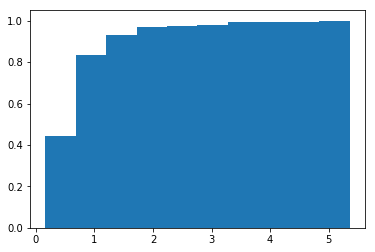

Intervalos:
[0, 1, 2, 6]
Probabilidades acumuladas:
[0.0, 0.76282, 0.95513, 1.0]


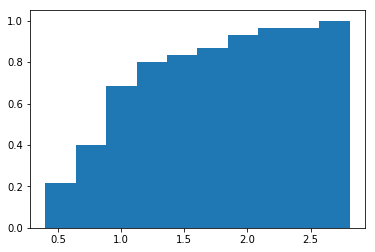

Intervalos:
[0, 1.2, 3]
Probabilidades acumuladas:
[0.0, 0.75, 1.0]


In [16]:
indicador = 'DEC'
conjunto = configuraConjuntoInicial(colunas=[indicador])
treino,teste = separaConjuntosDeTreinoETeste(conjunto=conjunto,dataReferencia='2013-01-01')


# treinoNormalizado,scalerTreino = normalizaConjunto(conjunto=treino)
probAcumuladaTreino,intervalosTreino = separaPorIntervalosDeProbabilidade(treino,intervalos=[0,1,2,6])
treinoNormalizado = normalizaSeriePorTrechos(serie=treino,trechos=intervalosTreino,probabilidades=probAcumuladaTreino)

# testeNormalizado,scalerTeste = normalizaConjunto(conjunto=teste)
probAcumuladaTeste,intervalosTeste = separaPorIntervalosDeProbabilidade(teste,intervalos=[0,1.2,3])
testeNormalizado = normalizaSeriePorTrechos(serie=teste,trechos=intervalosTeste,probabilidades=probAcumuladaTeste)


mesCodificadoTreino = codificaMesesDoConjunto(treinoNormalizado)
mesCodificadoTeste = codificaMesesDoConjunto(testeNormalizado)
treinoInput,treinoOutput = configuraConjuntosDeEntradaEDeReferencia(conjuntoDeDados=np.ndarray.flatten(treinoNormalizado.values),janelasDeObservacao=13,atraso=1,colunaAdicional=mesCodificadoTreino, labelColunaAdicional='mes_codificado')
testeInput,testeOutput = configuraConjuntosDeEntradaEDeReferencia(conjuntoDeDados=np.ndarray.flatten(testeNormalizado.values),janelasDeObservacao=13,atraso=1,colunaAdicional=mesCodificadoTeste, labelColunaAdicional='mes_codificado')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                195       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 14        
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


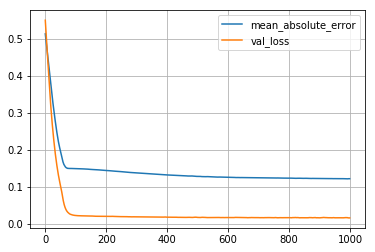

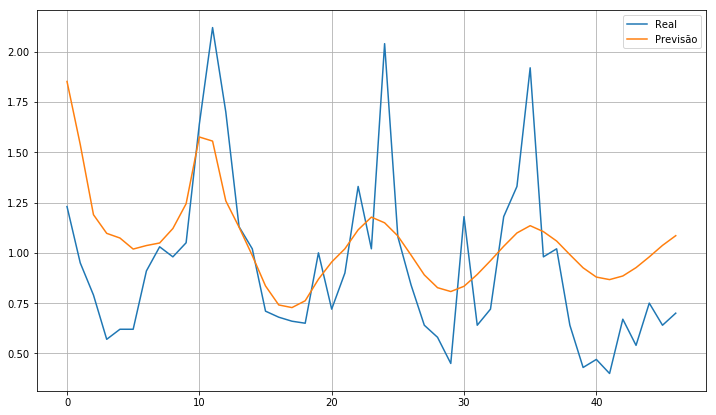

Root Mean Squared Error: 0.346676
Mean Absolute Percentage Error: 35.830925


(0.34667577284310086, Série Normalizada    35.830925
 dtype: float64)

In [17]:
modelo = Sequential()
modelo,historico = configuraRedeMLP(conjuntoEntrada=treinoInput,conjuntoSaida=treinoOutput,neuronios_1=13,neuronios_2=None,showPlot=True)
prev_teste = []
prev_teste,real_teste = executaPrevisaoEmMultiEstagios(modelo=modelo,conjuntoEntradaInicial=testeInput,numeroEstagios=testeOutput.size,conjuntoSaida=testeOutput,inverterNormalizacaoSaida=True,probabilidades=probAcumuladaTeste,trechos=intervalosTeste,showPlot=True)
calculaErros(previsao=prev_teste,verdadeiro=real_teste)
# print(real_teste)

## Previsão dos dados de treino (um mes a frente):
# previsaoTreino = []
# previsaoTreino, dadosReaisTreino = executaPrevisaoDoModelo(modelo=modelo,conjuntoEntrada=treinoInput,conjuntoSaida=treinoOutput,scalerSaida=scalerTreino,showPlot=True)
# calculaErros(previsao=previsaoTreino,verdadeiro=dadosReaisTreino)

## Previsão dos dados de teste (um mês a frente): 
# previsaoTeste =[]
# previsaoTeste, dadosReaisTeste = executaPrevisaoDoModelo(modelo=modelo,conjuntoEntrada=testeInput,conjuntoSaida=testeOutput,scalerSaida=scalerTeste,showPlot=True)
# calculaErros(previsao=previsaoTeste,verdadeiro=dadosReaisTeste)


            Previsão do DEC
Data                       
2014-09-01         0.802986
2014-10-01         0.853061
2014-11-01         0.875046
2014-12-01         0.890264
2015-01-01         0.756547
2015-02-01         0.751251
2015-03-01         0.718098
2015-04-01         0.714589
2015-05-01         0.722954
2015-06-01         0.738724
2015-07-01         0.752722
2015-08-01         0.778961
2015-09-01         0.720856
2015-10-01         0.756881
2015-11-01         0.800823
2015-12-01         0.829631
2016-01-01         0.869102
2016-02-01         0.744251
2016-03-01         0.733218
2016-04-01         0.716206
2016-05-01         0.709029
2016-06-01         0.719775
2016-07-01         0.737740
2016-08-01         0.751645
2016-09-01         0.777884
2016-10-01         0.801200
2016-11-01         0.826611
2016-12-01         0.853539
2017-01-01         0.880462
2017-02-01         0.753780
2017-03-01         0.738191
2017-04-01         0.719734
2017-05-01         0.710932
2017-06-01         0

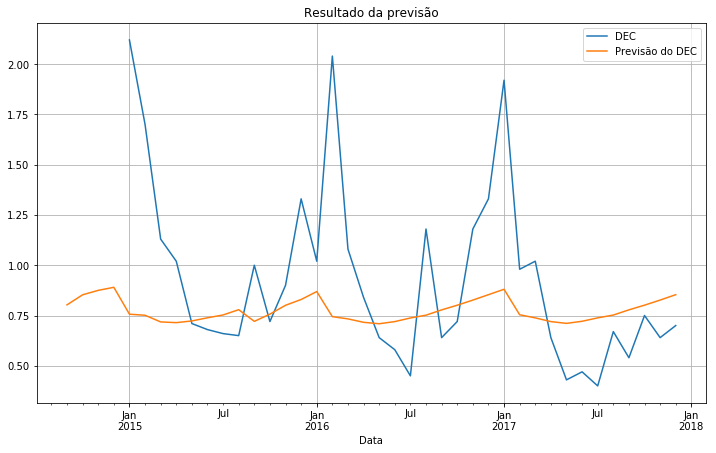

In [746]:
conjunto = converteDataStringParaDateTime(conjunto)
conjunto = conjunto.loc['01-01-2015':'12-01-2017']
# prev_teste pd.DataFrame(prev_teste, columns=['Previsão do FEC'],
previsao_final = pd.DataFrame(prev_teste.values, columns=['Previsão do DEC'], index= pd.to_datetime(teste.iloc[-len(prev_teste):].index))
print(previsao_final)
ax = conjunto.plot(y=indicador,figsize=(12,7))
previsao_final.plot(y='Previsão do DEC',ax=ax)
plt.title('Resultado da previsão')
plt.grid(True)
plt.show()